# GAN Model

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pdb

# torch imports
import torch
from torch.utils.data import DataLoader,Dataset
from torch import optim,nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.utils as vutils

# Models

## ResNet 18

In [3]:
# ResNet Classifier
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=7):
        super(ResNet, self).__init__()
        self.in_planes = 16
        self.embDim = 128 * block.expansion
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 128, num_blocks[3], stride=2)
        self.linear = nn.Linear(128 * block.expansion, num_classes)
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        emb = out.view(out.size(0), -1)
        out = self.linear(emb)
        return out#, emb
    def get_embedding_dim(self):
        return self.embDim

def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

## DC Generator

This is the DC Generator PyTorch Implementation. We edited this model into a 32x32 version instead of the standard 64x64 version. 

In [4]:

class DCGAN_generator(nn.Module):
  """

  Attributes
  ----------
    ngpu : int
      The number of available GPU devices

  """
  def __init__(self, ngpu):
    """Init function

    Parameters
    ----------
      ngpu : int
        The number of available GPU devices

    """
    super(DCGAN_generator, self).__init__()
    self.ngpu = ngpu
    
    nz = 100 # noise dimension
    ngf = 64 # number of features map on the first layer
    nc = 3 # number of channels

    self.main = nn.Sequential(
      # input is Z, going into a convolution
      nn.ConvTranspose2d(     nz, ngf * 4, 4, 1, 0, bias=False),
      nn.BatchNorm2d(ngf * 4),
      nn.ReLU(True),
      # state size. (ngf*8) x 4 x 4
      nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
      nn.BatchNorm2d(ngf * 2),
      nn.ReLU(True),
      # state size. (ngf*4) x 8 x 8
      nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
      nn.BatchNorm2d(ngf),
      nn.ReLU(True),
      # state size. (ngf*2) x 16 x 16
      nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
      nn.Tanh()
      # state size. (nc) x 64 x 64
    )

  def forward(self, input):
    """Forward function

    Parameters
    ----------
    input : :py:class:`torch.Tensor`
    
    Returns
    -------
    :py:class:`torch.Tensor`
      the output of the generator (i.e. an image)

    """
    output = self.main(input)
    return output

## DC Discriminator

This is the DC Discriminator PyTorch Implementation. We edited this model into a 32x32 version instead of the standard 64x64 version. 

In [5]:
class DCGAN_discriminator(nn.Module):
  """ 

  Attributes
  ----------
    ngpu : int
      The number of available GPU devices

  """
  def __init__(self, ngpu):
    """Init function

    Parameters
    ----------
      ngpu : int
        The number of available GPU devices

    """
    super(DCGAN_discriminator, self).__init__()
    self.ngpu = ngpu
        
    ndf = 64
    nc = 3
       
    self.main = nn.Sequential(
      nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
      nn.BatchNorm2d(ndf),
      nn.LeakyReLU(0.2, inplace=True),

      nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
      nn.BatchNorm2d(ndf * 2),
      nn.LeakyReLU(0.2, inplace=True),
      # state size. (ndf*4) x 8 x 8
      nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
      nn.BatchNorm2d(ndf * 4),
      nn.LeakyReLU(0.2, inplace=True),
      # state size. (ndf*8) x 4 x 4
      nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
      nn.Sigmoid()
    )

  def forward(self, input):
    """Forward function

    Parameters
    ----------
    input : :py:class:`torch.Tensor`
    
    Returns
    -------
    :py:class:`torch.Tensor`
      the output of the generator (i.e. an image)

    """
    output = self.main(input)

    return output.view(-1, 1).squeeze(1)

# Data Pre-Processing

In [24]:
transform = transforms.Compose([
    transforms.Resize(32), #CB add. Bridge dataset is 224x224 and needs to be 32x32
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #CB add
    ])

transform_train = transforms.Compose([
    transforms.Resize(32), #CB add. Bridge dataset is 224x224 and needs to be 32x32                                
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.Resize(32), #CB add. Bridge dataset is 224x224 and needs to be 32x32
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# CB Implementation
# load directory location
data_dir = '/content/drive/MyDrive/Colab Notebooks/data/Goldengate Bridge/output'

# regular data loaders
batch_size = 64
trainset = datasets.ImageFolder(data_dir + '/train', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = datasets.ImageFolder(data_dir + '/test', transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

print(trainloader.dataset.classes) #CB Addition
print(testloader.dataset.classes) #CB Addition
##

#create subsets
dataSizeConstant = 0.1
valDataFraction = 0.1
subset = np.random.permutation([i for i in range(len(trainset))])
subTrain = subset[:int(len(trainset) * (dataSizeConstant))]
subTrainSet = datasets.ImageFolder(data_dir + '/train', transform=transform_train) #CB Revised Original
subTrainLoader = DataLoader(subTrainSet, batch_size = batch_size, shuffle= False, num_workers= 2, sampler = torch.utils.data.SubsetRandomSampler(subTrain))

['10', '20', '30', '40', '50', '60', '70']
['10', '20', '30', '40', '50', '60', '70']


# Prepare for Training
We will initialize all of our models, optimizers, and loss functions. We will set important hyperparameters.

In [7]:
# define device 
device = torch.device("cuda:0")

# data for plotting purposes
generatorLosses = []
discriminatorLosses = []
classifierLosses = []

#training starts

epochs = 100

# models
netG = DCGAN_generator(1)
netD = DCGAN_discriminator(1)
netC = ResNet18()

netG.to(device)
netD.to(device)
netC.to(device)

# optimizers 
optD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay = 1e-3)
optG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
optC = optim.Adam(netC.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay = 1e-3)

advWeight = 0.1 # adversarial weight

loss = nn.BCELoss()
criterion = nn.CrossEntropyLoss()

file = open("ExternalClassifier.txt", "w")

# Training Loop

In [8]:
def train(datasetLoader):
  #file.write(text) #CB DEBUG: 9/19/21 # Commented out due to error. 'text' needs to be declared
  for epoch in range(epochs):
    netC.train()

    running_loss = 0.0
    total_train = 0
    correct_train = 0
    for i, data in enumerate(subTrainLoader, 0):
      
      dataiter = iter(subTrainLoader)
      inputs, labels = dataiter.next()
      inputs, labels = inputs.to(device), labels.to(device)
      tmpBatchSize = len(labels)  

      # create label arrays 
      true_label = torch.ones(tmpBatchSize, 1, device=device)
      fake_label = torch.zeros(tmpBatchSize, 1, device=device)

      r = torch.randn(tmpBatchSize, 100, 1, 1, device=device)
      fakeImageBatch = netG(r)

      real_cpu = data[0].to(device)
      batch_size = real_cpu.size(0)

      # train discriminator on real images
      predictionsReal = netD(inputs)
      true_label = true_label.squeeze(1) #CB ADD: 9/19/21 # Fixes different target input sizes for loss()
      lossDiscriminator = loss(predictionsReal, true_label) #labels = 1
      lossDiscriminator.backward(retain_graph = True)

      # train discriminator on fake images
      predictionsFake = netD(fakeImageBatch)
      fake_label = fake_label.squeeze(1) #CB ADD: 9/19/21 # Fixes different target input sizes for loss()
      lossFake = loss(predictionsFake, fake_label) #labels = 0
      lossFake.backward(retain_graph= True)
      optD.step() # update discriminator parameters    

      # train generator 
      optG.zero_grad()
      predictionsFake = netD(fakeImageBatch)
      lossGenerator = loss(predictionsFake, true_label) #labels = 1
      lossGenerator.backward(retain_graph = True)
      optG.step()

      torch.autograd.set_detect_anomaly(True)
      fakeImageBatch = fakeImageBatch.detach().clone()

      # train classifier on real data
      predictions = netC(inputs)
      realClassifierLoss = criterion(predictions, labels)
      realClassifierLoss.backward(retain_graph=True)
      
      optC.step()
      optC.zero_grad()

      # update the classifer on fake data
      predictionsFake = netC(fakeImageBatch)
      # get a tensor of the labels that are most likely according to model
      predictedLabels = torch.argmax(predictionsFake, 1) # -> [0 , 5, 9, 3, ...]
      confidenceThresh = .2

      # psuedo labeling threshold
      probs = F.softmax(predictionsFake, dim=1)
      mostLikelyProbs = np.asarray([probs[i, predictedLabels[i]].item() for  i in range(len(probs))])
      toKeep = mostLikelyProbs > confidenceThresh
      if sum(toKeep) != 0:
          fakeClassifierLoss = criterion(predictionsFake[toKeep], predictedLabels[toKeep]) * advWeight
          fakeClassifierLoss.backward()
          
      optC.step()

      # reset the gradients
      optD.zero_grad()
      optG.zero_grad()
      optC.zero_grad()

      # save losses for graphing
      generatorLosses.append(lossGenerator.item())
      discriminatorLosses.append(lossDiscriminator.item())
      classifierLosses.append(realClassifierLoss.item())

      # get train accurcy 
      if(i % 100 == 0):
        netC.eval()
        # accuracy
        _, predicted = torch.max(predictions, 1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels.data).sum().item()
        train_accuracy = 100 * correct_train / total_train
        text = ("Train Accuracy: " + str(train_accuracy))
        #file.write(text + '\n')
        netC.train()

    print("Epoch " + str(epoch) + "Complete")
    
    # save gan image
    gridOfFakeImages = torchvision.utils.make_grid(fakeImageBatch.cpu())
    torchvision.utils.save_image(gridOfFakeImages, "/content/drive/MyDrive/Colab Notebooks/EC-GAN/content/BridgeFakeImages/FakeImage" + str(epoch) + '_' + str(i) + '.png') #CB UPDATE: 9/19/21 # Updates folder path
    validate()

In [9]:
def validate():
  netC.eval()
  correct = 0
  total = 0
  with torch.no_grad():
      for data in testloader:
          inputs, labels = data
          inputs, labels = data[0].to(device), data[1].to(device)
          outputs = netC(inputs)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  accuracy = (correct / total) * 100 

  print('Accuracy of the network on the 10000 test images: %d %%' % (
      100 * correct / total))

  text = ("Test Accuracy: " + str(accuracy) + "\n")
  file.write(text)
  netC.train()

In [10]:
train(subTrainLoader)
file.close()

Epoch 0Complete
Accuracy of the network on the 10000 test images: 12 %
Epoch 1Complete
Accuracy of the network on the 10000 test images: 12 %
Epoch 2Complete
Accuracy of the network on the 10000 test images: 12 %
Epoch 3Complete
Accuracy of the network on the 10000 test images: 13 %
Epoch 4Complete
Accuracy of the network on the 10000 test images: 13 %
Epoch 5Complete
Accuracy of the network on the 10000 test images: 12 %
Epoch 6Complete
Accuracy of the network on the 10000 test images: 13 %
Epoch 7Complete
Accuracy of the network on the 10000 test images: 13 %
Epoch 8Complete
Accuracy of the network on the 10000 test images: 14 %
Epoch 9Complete
Accuracy of the network on the 10000 test images: 13 %
Epoch 10Complete
Accuracy of the network on the 10000 test images: 13 %
Epoch 11Complete
Accuracy of the network on the 10000 test images: 14 %
Epoch 12Complete
Accuracy of the network on the 10000 test images: 14 %
Epoch 13Complete
Accuracy of the network on the 10000 test images: 11 %
Ep

## Plot Losses

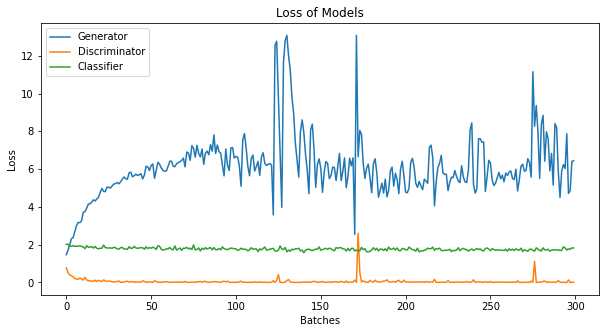

In [11]:
# plot losses
plt.figure(figsize=(10,5))
plt.title("Loss of Models")
plt.plot(generatorLosses,label="Generator")
plt.plot(discriminatorLosses,label="Discriminator")
plt.plot(classifierLosses, label = "Classifier")
plt.xlabel("Batches")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Classifier

Classifier with different dataset sizes and generated images

In [12]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pdb

# torch imports
import torch
from torch.utils.data import DataLoader,Dataset
from torch import optim,nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data
import torchvision.utils as vutils
from torch.autograd import Variable

# model
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=7):
        super(ResNet, self).__init__()
        self.in_planes = 16
        self.embDim = 128 * block.expansion
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 128, num_blocks[3], stride=2)
        self.linear = nn.Linear(128 * block.expansion, num_classes)
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        emb = out.view(out.size(0), -1)
        out = self.linear(emb)
        return out#, emb
    def get_embedding_dim(self):
        return self.embDim

def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

In [25]:
#data preprocessing

file = open("StandardClassifier.txt", "w")

transform_augment = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform = transforms.Compose([
    transforms.Resize(32), #CB added
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# CB Implementation
# load directory location
data_dir = '/content/drive/MyDrive/Colab Notebooks/data/Goldengate Bridge/output'

# regular data loaders
batch_size = 64
trainset = datasets.ImageFolder(data_dir + '/train', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = datasets.ImageFolder(data_dir + '/test', transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
##

#create subsets
dataSizeConstant = 0.25
valDataFraction = 0.1
subset = np.random.permutation([i for i in range(len(trainset))])
subTrain = subset[:int(len(trainset) * (dataSizeConstant))]
subTrainSet = datasets.ImageFolder(data_dir + '/train', transform=transform_train)
subTrainLoader = DataLoader(subTrainSet, batch_size = batch_size, shuffle= False, num_workers= 2, sampler = torch.utils.data.SubsetRandomSampler(subTrain))

In [26]:
# define device 
device = torch.device("cuda:0")

# data for plotting purposes
modelLoss = []

# model
# model = ResNet(BasicBlock, [2,2,2,2])
model = ResNet18()
model.to(device)

opt = optim.Adam(model.parameters(), lr=0.0001, betas=(0.5, 0.999))
criterion = nn.CrossEntropyLoss()

epochs = 100

In [27]:
#training starts

def train(datasetLoader):
  text = ("Datasize: " + str(dataSizeConstant) + "\n")
  file.write(text)
  for epoch in range(epochs):
    model.train()

    running_loss = 0.0
    total_train = 0
    correct_train = 0
    for i, data in enumerate(datasetLoader, 0):
      dataiter = iter(datasetLoader)
      inputs, labels = dataiter.next()
      inputs, labels = inputs.to(device), labels.to(device)

      opt.zero_grad()

      outputs = model(inputs)
      modelLoss = criterion(outputs, labels) # error line
      modelLoss.backward()
      opt.step()

      model.eval()
      # accuracy
      _, predicted = torch.max(outputs, 1)
      total_train += labels.size(0)
      correct_train += predicted.eq(labels.data).sum().item()
      train_accuracy = 100 * correct_train / total_train                                   

      # save generated images 
      if(i % 1 == 0):
        text = ("Train Accuracy: " + str(train_accuracy))
        file.write(text + '\n')



    print("Epoch " + str(epoch) + " Complete")
    print("Loss: " + str(modelLoss.item()))
    validate()

In [28]:
# validation 
def validate():
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
      for data in testloader:
          inputs, labels = data
          inputs, labels = data[0].to(device), data[1].to(device)
          outputs = model(inputs)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  accuracy = (correct / total) * 100 

  print('Accuracy of the network on the 10000 test images: %d %%' % (
      100 * correct / total))

  text = ("Test Accuracy: " + str(accuracy) + "\n")
  file.write(text)
  model.train()

In [29]:
train(subTrainLoader)
file.close() 

Epoch 0 Complete
Loss: 1.9347305297851562
Accuracy of the network on the 10000 test images: 24 %
Epoch 1 Complete
Loss: 1.9322233200073242
Accuracy of the network on the 10000 test images: 24 %
Epoch 2 Complete
Loss: 1.9350849390029907
Accuracy of the network on the 10000 test images: 24 %
Epoch 3 Complete
Loss: 1.9295481443405151
Accuracy of the network on the 10000 test images: 24 %
Epoch 4 Complete
Loss: 1.932054042816162
Accuracy of the network on the 10000 test images: 24 %
Epoch 5 Complete
Loss: 1.9373779296875
Accuracy of the network on the 10000 test images: 24 %
Epoch 6 Complete
Loss: 1.9307986497879028
Accuracy of the network on the 10000 test images: 24 %
Epoch 7 Complete
Loss: 1.922255039215088
Accuracy of the network on the 10000 test images: 24 %
Epoch 8 Complete
Loss: 1.9540232419967651
Accuracy of the network on the 10000 test images: 24 %
Epoch 9 Complete
Loss: 1.918976902961731
Accuracy of the network on the 10000 test images: 24 %
Epoch 10 Complete
Loss: 1.9661751985

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1ed53f7ef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1ed53f7ef0>
Traceback (most recent call last):
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
AssertionError: can only test a child process
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1ed53f7ef0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/d

Epoch 36 Complete
Loss: 1.9045515060424805
Accuracy of the network on the 10000 test images: 24 %
Epoch 37 Complete
Loss: 1.8415589332580566
Accuracy of the network on the 10000 test images: 24 %
Epoch 38 Complete
Loss: 1.9647977352142334
Accuracy of the network on the 10000 test images: 13 %
Epoch 39 Complete
Loss: 1.8636490106582642
Accuracy of the network on the 10000 test images: 23 %
Epoch 40 Complete
Loss: 1.907348394393921
Accuracy of the network on the 10000 test images: 12 %
Epoch 41 Complete
Loss: 1.9544427394866943
Accuracy of the network on the 10000 test images: 18 %
Epoch 42 Complete
Loss: 1.8971576690673828
Accuracy of the network on the 10000 test images: 22 %
Epoch 43 Complete
Loss: 1.9084510803222656
Accuracy of the network on the 10000 test images: 22 %
Epoch 44 Complete
Loss: 1.8640046119689941
Accuracy of the network on the 10000 test images: 18 %
Epoch 45 Complete
Loss: 1.910660982131958
Accuracy of the network on the 10000 test images: 23 %
Epoch 46 Complete
Loss